In [63]:
import boto3
import pandas as pd; pd.set_option('display.max_column', 100)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score
## define bucket in which you are trying to reach
s3 = boto3.resource('s3')
bucket_name = 'daltondencklau-data445-bucket'
bucket = s3.Bucket(bucket_name)

## define csv file to read in the bucket
file_key= 'churn-bigml-80.csv'

## syntax to allow us to read the file
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## reading the data file
telecom_train = pd.read_csv(file_content_stream)
telecom_train.head()

## disabling the 'FutureWarning' warning message
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

telecom_train.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [64]:
## define csv file to read in the bucket
file_key= 'churn-bigml-20.csv'

## syntax to allow us to read the file
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## reading the data file
telecom_test = pd.read_csv(file_content_stream)
telecom_test.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


In [65]:
## changing the variable 'churn' from categorical to numerical variable (True = 1, False = 0) in both data frames
telecom_train['Churn'] = np.where(telecom_train['Churn'] == False, 0, 1)
telecom_test['Churn'] = np.where(telecom_test['Churn'] == False, 0, 1)

In [66]:
## changing the variable 'International_plan' from categorical to numerical variable (Yes = 1, False = 0) in both data frames
telecom_train['International_plan'] = np.where(telecom_train['International_plan'] == 'No', 0, 1)
telecom_test['International_plan'] = np.where(telecom_test['International_plan'] == 'No', 0, 1)

In [67]:
## changing the variable 'Voice_mail_plan' from categorical to numerical variable (Yes = 1, False = 0) in both data frames
telecom_train['Voice_mail_plan'] = np.where(telecom_train['Voice_mail_plan'] == 'No', 0, 1)
telecom_test['Voice_mail_plan'] = np.where(telecom_test['Voice_mail_plan'] == 'No', 0, 1)

In [68]:
## creating a new variable called 'total_charge' in train data frame
telecom_train = telecom_train.assign(total_charge = telecom_train['Total_day_charge'] + telecom_train['Total_eve_charge'] + telecom_train['Total_night_charge'] + telecom_train['Total_intl_charge'])
telecom_test = telecom_test.assign(total_charge = telecom_test['Total_day_charge'] + telecom_test['Total_eve_charge'] + telecom_test['Total_night_charge'] + telecom_test['Total_intl_charge'])

telecom_test.head()


,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn,total_charge
0,LA,117,408,0,0,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,0,73.32
1,IN,65,415,0,0,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,1,54.20
2,NY,161,415,0,0,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,1,92.29
3,SC,111,415,0,0,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,0,41.05
4,HI,49,510,0,0,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,0,49.60


In [69]:
## defining input and target variables
X_training = telecom_train[['Account_length', 'International_plan', 'Voice_mail_plan', 'total_charge', 'Customer_service_calls']]
Y_training = telecom_train['Churn']

X_test = telecom_test[['Account_length', 'International_plan', 'Voice_mail_plan', 'total_charge', 'Customer_service_calls']]
Y_test = telecom_test['Churn']

In [70]:
## defining the list to store results
coeffs = list()

## creating loop to preform LASSO variable selection
for i in range(0,1000):
    
    # print(i)

    ## splitting data into training and testing datasets
    X_train, X_test, Y_train, Y_test = train_test_split(X_training, Y_training, test_size = 0.2, stratify = Y_training)
    
    ## transforming the data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    
    ## estimating lambda for lasso by CV with 5 folds
    lasso_cv = LassoCV(normalize = True, cv = 5).fit(X_train, Y_train)

    ## extracting the best lambda value via cross validation
    cv_lambda = lasso_cv.alpha_
    
    ## building the lasso model and capturing coefficients
    lasso_md = Lasso(alpha = cv_lambda, normalize = True).fit(X_train, Y_train)
    coeffs.append(lasso_md.coef_)

## creating a dataframe from array/list to store results
df_coeffs = pd.DataFrame(coeffs, columns = [['Account_length', 'International_plan', 'Voice_mail_plan', 'total_charge', 'Customer_service_calls']])
df_coeffs

,Account_length,International_plan,Voice_mail_plan,total_charge,Customer_service_calls
0,-0.000000,0.323420,-0.065905,0.503104,0.512677
1,0.029408,0.301362,-0.073323,0.496738,0.536959
2,0.031693,0.306593,-0.083892,0.558723,0.490859
3,-0.000000,0.306492,-0.084494,0.474537,0.548204
4,-0.000000,0.334530,-0.067209,0.477669,0.525728
...,...,...,...,...,...
995,0.016066,0.290986,-0.074300,0.528645,0.523298
996,0.012766,0.308122,-0.076470,0.466187,0.499107
997,-0.014232,0.319372,-0.085101,0.508893,0.560436
998,0.000000,0.324775,-0.082131,0.511955,0.501232


In [71]:
## counting all 0s in each column
count_0 = (df_coeffs ==0).sum()
count_0

print(count_0)

print('I need to drop the Account_length variable because it has over 200 coefficients = 0')

Account_length            260
International_plan          0
Voice_mail_plan             0
total_charge                0
Customer_service_calls      0
dtype: int64
I need to drop the Account_length variable because it has over 200 coefficients = 0


In [72]:
## removing features with coefficients = 0 more than 200 times
X_training = X_training.drop(columns = ['Account_length'], axis = 1)
X_test = X_test.drop(columns = ['Account_length'], axis = 1)

In [73]:
## create list to store results

mdA_results = list()
mdB_results = list()
mdC_results = list()
mdD_results = list()

## creating a loop to repeat part E 100 times

for i in range (0,100):
    
    #print(i)
    
    ## define k folds
    kf = StratifiedKFold(n_splits = 5, shuffle = True)

    mdA_fold_results = list()
    mdB_fold_results = list()
    mdC_fold_results = list()
    mdD_fold_results = list()

    for train_idx, val_idx in kf.split(X_training, Y_training):

        ## splitting the data into train and validation
        X_train, X_val = X_training.iloc[train_idx], X_training.iloc[val_idx]
        Y_train, Y_val = Y_training.iloc[train_idx], Y_training.iloc[val_idx]
    
        ## scaling the data
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.fit_transform(X_val)
    
        ## Building the logistic regression models
        mdA = LogisticRegression(solver = 'liblinear', penalty = 'l1').fit(X_train, Y_train)
        mdB = LogisticRegression(solver = 'liblinear', penalty = 'l2').fit(X_train, Y_train)
        mdC = LogisticRegression(solver = 'saga', penalty = 'l1').fit(X_train, Y_train)
        mdD = LogisticRegression(solver = 'saga', penalty = 'l2').fit(X_train, Y_train)

        ## Predicting on the validation set
        predA = mdA.predict_proba(X_val)[:,1]
        predB = mdB.predict_proba(X_val)[:,1]
        predC = mdC.predict_proba(X_val)[:,1]
        predD = mdD.predict_proba(X_val)[:,1]

        ## setting 10% cutoff and creating labels for transformation
        predA_labels = np.where(predA < 0.1, 0, 1)
        predB_labels = np.where(predB < 0.1, 0, 1)
        predC_labels = np.where(predC < 0.1, 0, 1)
        predD_labels = np.where(predD < 0.1, 0, 1)

        ## calculating recall score for all models
        mdA_recall = recall_score(Y_val, predA_labels)
        mdB_recall = recall_score(Y_val, predB_labels)
        mdC_recall = recall_score(Y_val, predC_labels)
        mdD_recall = recall_score(Y_val, predD_labels)

        ## storing recall score in a list
        mdA_fold_results.append(mdA_recall)
        mdB_fold_results.append(mdB_recall)
        mdC_fold_results.append(mdC_recall)
        mdD_fold_results.append(mdD_recall)
        
    ## reporting the average for each iteration
    avg_A = np.mean(mdA_fold_results)
    mdA_results.append(avg_A)
    #print(mdA_results)

    avg_B = np.mean(mdB_fold_results)
    mdB_results.append(avg_B)
    #print(mdB_results)

    avg_C = np.mean(mdC_fold_results)
    mdC_results.append(avg_C)
    #print(mdC_results)

    avg_D = np.mean(mdD_fold_results)
    mdD_results.append(avg_D)
    #print(mdD_results)
        
        #print(md1_fold_results)
        #print(md2_fold_results)
        #print(md3_fold_results)
        #print(md4_fold_results)

In [74]:
## reporting the average recall for each model
print('The average recall for model 1 is', avg_A)
print('The average recall for model 2 is', avg_B)
print('The average recall for model 3 is', avg_C)
print('The average recall for model 4 is', avg_D)

The average recall for model 1 is 0.884115884115884
The average recall for model 2 is 0.8969696969696969
The average recall for model 3 is 0.884115884115884
The average recall for model 4 is 0.8944055944055943


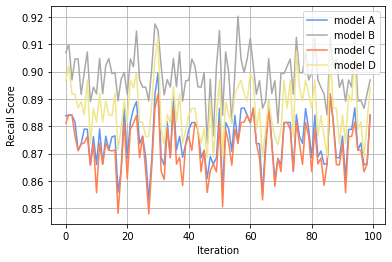

In [122]:
## visualizing the recall scores for each model at each iteration
##iteration = [i for i in range(0,100)]
plt.plot(mdA_results, color = 'cornflowerblue')
plt.plot(mdB_results, color = 'darkgray')
plt.plot(mdC_results, color = 'coral')
plt.plot(mdD_results, color = 'khaki')
plt.xlabel('Iteration')
plt.ylabel('Recall Score')
plt.legend(loc = 'upper right', labels = ['model A', 'model B', 'model C', 'model D'])
plt.grid()
plt.show();

In [104]:
## disabling the 'UserWarning' warning message
import warnings
warnings.simplefilter(action = 'ignore', category = UserWarning)

In [108]:
## defining variables to use for the last model
X_logit_train = telecom_train[['Account_length', 'International_plan', 'Voice_mail_plan', 'total_charge', 'Customer_service_calls']]
Y_logit_train = telecom_train['Churn']

X_logit_test = telecom_test[['Account_length', 'International_plan', 'Voice_mail_plan', 'total_charge', 'Customer_service_calls']]
Y_logit_test = telecom_test['Churn']

## splitiing the data into training and tesring
X_logit_training, X_logit_testing, Y_logit_training, Y_logit_testing = train_test_split(X_logit_train, Y_logit_train, test_size = 0.2, stratify = Y_logit_train)

## using minmaxscaler to transform(0-1) the input and target variables in training and testing datasets
scaler = MinMaxScaler()
X_logit_training = scaler.fit_transform(X_logit_training)
X_logit_testing = scaler.fit_transform(X_logit_testing)


In [123]:
## Building the logistic regression models
## I am using Model B and Model D from part F because they preformed the best (highest recall scores)
logit_mdA = LogisticRegression(solver = 'liblinear', penalty = 'l2').fit(X_logit_training, Y_logit_training)
logit_mdB = LogisticRegression(solver = 'saga', penalty = 'l2').fit(X_logit_training, Y_logit_training)

## Predicting on the testing dataset
pred_logit_mdA = logit_mdA.predict_proba(X_logit_testing)[:,1]
pred_logit_mdB = logit_mdB.predict_proba(X_logit_testing)[:,1]

## setting 10% cutoff and creating labels for transformation
predA2_labels = np.where(pred_logit_mdA < 0.1, 0, 1)
predB2_labels = np.where(pred_logit_mdB < 0.1, 0, 1)

## calculating recall score for all models
mdA2_recall = recall_score(Y_logit_testing, predA2_labels)
mdB2_recall = recall_score(Y_logit_testing, predB2_labels)

print('The recall score for model A is', mdA2_recall)
print('The recall score for model B is', mdB2_recall)

The recall score for model A is 0.8717948717948718
The recall score for model B is 0.8461538461538461


Based on these Recall scores, I would choose model A to predict Churn because it has the highest recall score.